In [1]:
import socket

NB='test2'
DESCRIPTION='test notebook'
HOST = socket.gethostname()
HOST

'DESKTOP-7KHT10A'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import re
from pathlib import Path
import pickle
from transformers import AutoTokenizer, AutoConfig
import random
from logzero import logger
import os
import gc
import warnings
warnings.simplefilter('ignore')

ROOT_DIR = Path('../')
DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = Path('../') / 'output'
CP_DIR = OUTPUT_DIR / 'checkpoint'

def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def unpickle(filename):
    with open(filename, mode='rb') as fo:
        p = pickle.load(fo)
    return p 

In [3]:
class Config:
    N_LABEL = 1
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 1.0e-05
    MAX_LR = 3.0e-5
    PATIENCE = 3
    EPOCH = 10
    BATCH_SIZE = 16
    SKIP_EVALUATE_NUM = 0
    MODEL_NAME = 'huggingface/CodeBERTa-small-v1'
    RUN_FOLD_COUNT = 10
    IMG_SIZE=384
    T_MAX=20
    ETA_MIN=3.0e-7
    SCHEDULER_GAMMA=1.0
    ACCUMULATION_STEMP=2
    
    MAX_LEN = 256
    
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=Config.RANDOM_SATE)

In [4]:
train_df = pd.read_csv(DATA_DIR / 'tweet_train.csv')
#_train_df = train_df[['code', 'label']]
#_train_df.columns = ['text', 'target']

test_df = pd.read_csv(DATA_DIR / 'tweet_test.csv')
#_test_df = test_df[['code']]
#_test_df.columns = ['text']

display(train_df.shape)
display(test_df.shape)

display(train_df.head(3))
display(test_df.head(3))

(7613, 5)

(3263, 4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    Config.MODEL_NAME,
    do_lower_case=True,
    truncation=True
)

In [6]:
class BERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, data_type='train'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data_type = data_type
        
    def __getitem__(self, index):
        txt = str(self.data.text[index])
        inputs = self.tokenizer.encode_plus(
            txt,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if self.data_type == 'test':
            targets = -1
        else:
            targets = torch.tensor(self.data.target[index], dtype=torch.float)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': targets
        }
        
    def __len__(self):
        return len(self.data)

In [7]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(Config.MODEL_NAME)
        self.bert = transformers.AutoModel.from_pretrained(Config.MODEL_NAME)
        self.drop = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(self.config.hidden_size, 1)
    
    def forward(self, ids, mask):
        distilbert_output = self.bert(ids, mask)
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        output_1 = self.drop(pooled_output)
        output = self.out(output_1)
        return output

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=''):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            logger.info(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt')
        self.val_loss_min = val_loss

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

====== 0 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 12.46it/s]
[I 220916 00:59:25 <timed exec>:80] auc:0.7980
[I 220916 00:59:25 <ipython-input-8-6710d1759379>:29] Validation loss decreased (inf -->

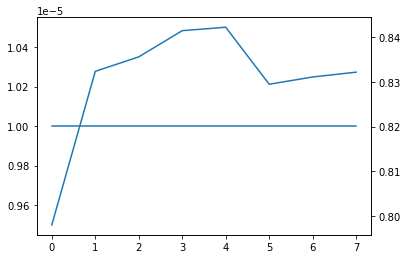

====== 1 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.63it/s]
[I 220916 01:14:03 <timed exec>:80] auc:0.7875
[I 220916 01:14:03 <ipython-input-8-6710d1759379>:29] Validation loss decreased (inf -->

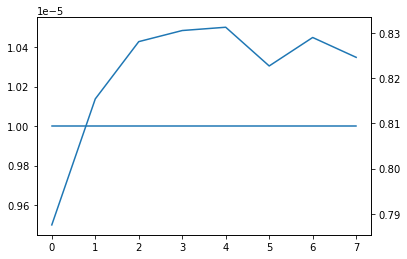

====== 2 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.57it/s]
[I 220916 01:28:51 <timed exec>:80] auc:0.7990
[I 220916 01:28:51 <ipython-input-8-6710d1759379>:29] Validation loss decreased (inf -->

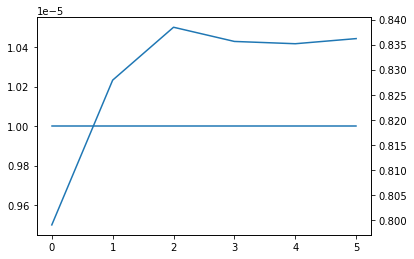

====== 3 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.52it/s]
[I 220916 01:39:58 <timed exec>:80] auc:0.8004
[I 220916 01:39:58 <ipython-input-8-6710d1759379>:29] Validation loss decreased (inf -->

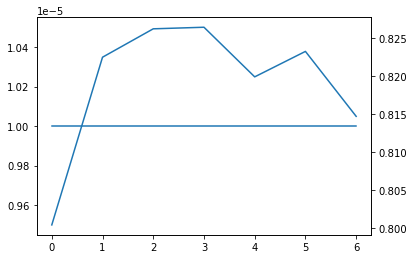

====== 4 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:08<00:00, 11.54it/s]
[I 220916 01:52:57 <timed exec>:80] auc:0.8096
[I 220916 01:52:57 <ipython-input-8-6710d1759379>:29] Validation loss decreased (inf -->

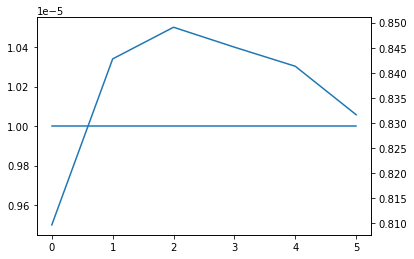

Wall time: 1h 4min 32s


In [10]:
%%time
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'====== {fold} ======')

    net = BERTClass()
    net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(net.parameters(), lr=Config.LR, weight_decay=1.0e-02)    

    _train, _valid = train_df.iloc[train_index].reset_index(drop=True), train_df.iloc[test_index].reset_index(drop=True)

    training_set = BERTDataset(_train, tokenizer, Config.MAX_LEN, data_type='train')
    validation_set = BERTDataset(_valid, tokenizer, Config.MAX_LEN, data_type='valid')

    trainloader = DataLoader(training_set, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=True)
    validloader = DataLoader(validation_set, batch_size=Config.BATCH_SIZE)

    early_stopping = EarlyStopping(patience=Config.PATIENCE, verbose=True, fold=fold)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=Config.EPOCH, steps_per_epoch=len(trainloader), max_lr=Config.MAX_LR, pct_start= 0.1, anneal_strategy='cos', div_factor= 1.0e+3, final_div_factor= 1.0e+3)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.T_MAX, eta_min=Config.ETA_MIN)
    # scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=int((len(trainloader) * Config.EPOCH) / 5), cycle_mult=1.0, max_lr=Config.LR, min_lr=Config.ETA_MIN, warmup_steps=int((len(trainloader) * Config.EPOCH) / 50), gamma=Config.SCHEDULER_GAMMA)

    val_losses = []
    val_metrics = []
    train_metrics = []
    lrs = []

    for epoch in range(Config.EPOCH):

        running_loss = 0.0
        train_rmse_list = []
        n_iter = len(trainloader)
        with tqdm(enumerate(trainloader), total=n_iter) as pbar:
            for i, (data) in pbar:

                net.train()

                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)


                outputs = outputs = net(ids, mask).squeeze()

                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()
                net.zero_grad()     

                # print statistics
                running_loss += loss.item()

                outputs = outputs.sigmoid()

                pbar.set_postfix(OrderedDict(
                    epoch="{:>10}".format(epoch), loss="{:.4f}".format(loss.item())#, auc='{:.4f}'.format(auc)
                ))
                #scheduler.step()

        val_loss = 0.0
        val_lwlrap = 0.0
        val_preds = []
        n_iter_val = len(validloader)
        for i, (data) in tqdm(enumerate(validloader), total=n_iter_val):
            net.eval()

            with torch.no_grad():

                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = outputs = net(ids, mask).squeeze()
                outputs_np = outputs.to('cpu').detach().numpy().copy()
                val_preds.append(outputs_np)


        auc = roc_auc_score(_valid['target'], np.hstack(val_preds))
        logger.info('auc:{:.4f}'.format(auc))

        lr = optimizer.param_groups[0]['lr']

        val_metrics.append(auc)
        train_metrics.append(np.mean(train_rmse_list))
        lrs.append(lr)

        early_stopping(-auc, net)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))
            break

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(lrs)
    ax2 = ax1.twinx()
    ax2.plot(val_metrics)
    plt.show()

    del net, validloader, trainloader, training_set, validation_set
    torch.cuda.empty_cache()
    gc.collect()


In [14]:
%%time
cv_scores = {}
oof = np.zeros(len(train_df))
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'====== {fold} ======')

    net = BERTClass()
    net.to(device)

    _train, _valid = train_df.iloc[train_index].reset_index(drop=True), train_df.iloc[test_index].reset_index(drop=True)
    validation_set = BERTDataset(_valid, tokenizer, Config.MAX_LEN, data_type='valid')
    validloader = DataLoader(validation_set, batch_size=Config.BATCH_SIZE)

    preds = []
    n_iter_val = len(validloader)
    for i, (data) in tqdm(enumerate(validloader), total=n_iter_val):
        net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))
        net.eval()
        
        with torch.no_grad():

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = outputs = net(ids, mask).squeeze()
            outputs_np = outputs.to('cpu').detach().numpy().copy()
            preds.append(outputs_np)


    auc = roc_auc_score(_valid['target'], np.hstack(preds))
    print(auc)

    oof[test_index] = np.hstack(preds).reshape(-1)
    cv_scores[f'cv{fold}'] = auc

    del net, validation_set, validloader
    torch.cuda.empty_cache()
    gc.collect()


====== 0 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:22<00:00,  4.19it/s]


0.8422344953741161
====== 1 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:23<00:00,  4.14it/s]


0.8313292019017254
====== 2 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:23<00:00,  4.11it/s]


0.8384721093175396
====== 3 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:23<00:00,  4.13it/s]


0.8264816654687919
====== 4 ======


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:22<00:00,  4.20it/s]


0.8490774602235094
Wall time: 2min 9s


In [17]:
roc_auc_score(train_df['target'], oof)

0.8294407000029994

In [19]:
y_preds = np.zeros(len(test_df))

test_set = BERTDataset(test_df, tokenizer, Config.MAX_LEN, data_type='test')
testloader = DataLoader(test_set, batch_size=Config.BATCH_SIZE)

for fold in range(Config.N_FOLD):

    net = BERTClass()
    net.to(device)
    print(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt')
    net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))

    fold_preds = []
    for i, (data) in tqdm(enumerate(testloader), total=len(testloader)):
        net.eval()
        with torch.no_grad():
            
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = outputs = net(ids, mask).squeeze()
            outputs_np = outputs.to('cpu').detach().numpy().copy()

            fold_preds.append(outputs_np)
    
    y_preds += np.hstack(fold_preds).reshape(-1) / Config.N_FOLD

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


..\output\checkpoint\checkpoint_DESKTOP-7KHT10A_test2_0.pt


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:15<00:00, 12.94it/s]
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


..\output\checkpoint\checkpoint_DESKTOP-7KHT10A_test2_1.pt


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:15<00:00, 12.88it/s]
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


..\output\checkpoint\checkpoint_DESKTOP-7KHT10A_test2_2.pt


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:16<00:00, 12.70it/s]
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


..\output\checkpoint\checkpoint_DESKTOP-7KHT10A_test2_3.pt


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:16<00:00, 12.59it/s]
Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


..\output\checkpoint\checkpoint_DESKTOP-7KHT10A_test2_4.pt


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:16<00:00, 12.48it/s]


In [20]:
test_df['label'] = np.hstack(y_preds)
test_df[['id', 'label']].to_csv(OUTPUT_DIR / f'sub_{HOST}_{NB}.csv', index=False)